# `aisim` -- Simulations for light-pulse atom interferometry

## Installation

```
git clone https://github.com/bleykauf/aisim.git
cd aisim
python setup.py install
```

Alternatively, if you plan to make changes to the code, use

```
python setup.py develop
```

## Usage

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import aisim as ais

Checking the currently installed version:

In [2]:
print(ais.__version__)

v0.2.0+8.gcf80bca.dirty


## Examples

### Effect of wavefront aberrations in atom interferometry

As an example, we reproduce two plots from the paper https://link.springer.com/article/10.1007/s00340-015-6138-5.

The simulation will require the following objects and parameters
* `Wavefront`: contains the wavefront aberrations of the interferometry lasers
* `AtomicEnsemble`: an ensemble of atoms which different trajectors or phase space vectors
* `Detector`: determines which atoms contribute to the signal
* `t`: times of the three interferometer pulses

#### Loading and preparing wavefront data

Wavefront aberration in multiples of $\lambda$ = 780 nm. 

Load Zernike coefficients from file:

In [3]:
coeff_window2 = np.loadtxt('data/wf_window2.txt')
coeff_window5 = np.loadtxt('data/wf_window5.txt')

Creating `Wavefront` objects and removing piston, tip and tilt from the data:

In [4]:
r_beam = 11e-3 # radius of the available wavefront data in m

wf2 = ais.Wavefront(r_beam, coeff_window2)
wf5 = ais.Wavefront(r_beam, coeff_window5)
for n in [0,1,2]:
    wf2.coeff[n] = 0
    wf5.coeff[n] = 0

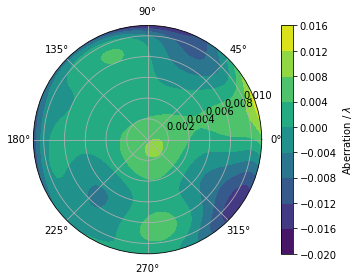

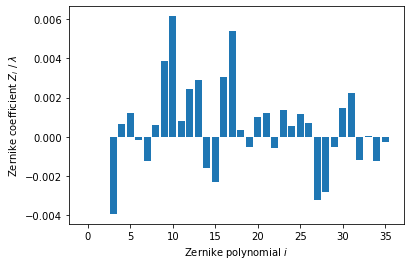

In [5]:
wf2.plot()
fig, ax = wf2.plot_coeff()

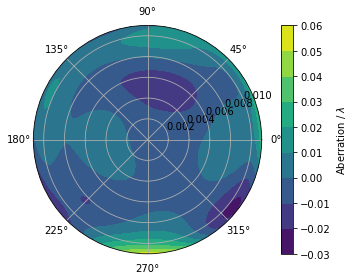

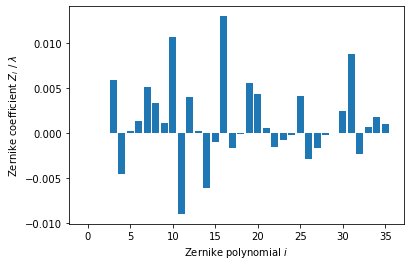

In [6]:
wf5.plot()
fig, ax = wf5.plot_coeff()

#### Creating an atomic ensemble

Due to the large number of parameters determining an atomic ensemble, dictionaries are used:

In [7]:
pos_params = {
    'std_rho' : 3.0e-3, # cloud radius in m
    'std_z' : 0,        # ignore z dimension, its not relevant here
    'n_rho' : 20,       # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,     # using a resolution of 10°
    'n_z' : 1,          # use one value for the distribution along z
    'm_std_rho' : 3,    # use 3 standard deviations of the distribution, i.e. atoms up to 9 mm away from the center
    'm_std_z' : 0,      # ignore z dimension, its not relevant here 
    'weight' : 'gauss'  # each point on the grid is weighted according to a Guassian distribution
}

vel_params = {
    'std_rho' : ais.vel_from_temp(3e-6), # velocity spread in m/s from a temperature of 3 uK
    'std_z' : 0,                         # ignore z dimension, its not relevant here
    'n_rho' : 20,                        # within each standard deviation of the distribution we use 20 points
    'n_theta' : 36,                      # using a resolution of 10°
    'n_z' : 1,                           # use one value for the distribution along z
    'm_std_rho' : 3,                     # use 3 standard deviations of the distribution
    'm_std_z' : 0,                       # ignore z dimension, its not relevant here 
    'weight' : 'gauss'                   # each point on the grid is weighted according to a Guassian distribution
}

atoms = ais.create_ensemble_from_grids(pos_params, vel_params, state_vectors=[0, 1])

Plotting the grid and the weights:

In [8]:
x = atoms.initial_position[:, 0]
y = atoms.initial_position[:, 1]

Text(0, 0.5, 'y / mm')

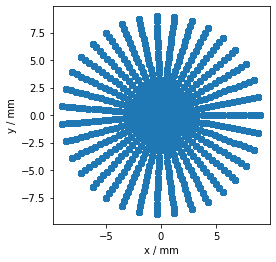

In [23]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, 1e3*y)
ax.set_aspect('equal', 'box')
ax.set_xlabel('x / mm')
ax.set_ylabel('y / mm')

Text(0, 0.5, 'weights')

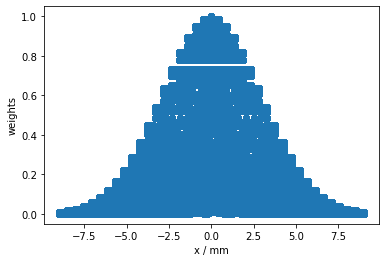

In [10]:
fig, ax = plt.subplots()
ax.scatter(1e3*x, atoms.weights)
ax.set_xlabel('x / mm')
ax.set_ylabel('weights')

#### Setting up the detector

We want to calculate the dependency of the phase shift caused by wavefront aberrations on the detection area. For this reason, we set up a Detector with varying detection radius within a for-loop.

In [11]:
t_det = 778e-3 # time of the detection in s

#### Simulation the bias in gravity from wavefront aberrations

For the simulation we need the objects created above and the timing of the interferometer sequence.

In [12]:
T = 260e-3 # interferometer time in s
t1 = 129.972e-3 # time of first pulse in s
t2 = t1 + T
t3 = t2 + T
t = [t1, t2, t3]

In [13]:
awf_win2 = []
awf_win5 = []
r_dets = np.linspace(2e-3, 10e-3, 10)
for r_det in r_dets:
    # creating detector with new detection radius
    det = ais.Detector(r_det, t_det)
    
    awf_win2.append(ais.wavefront_simulation(t, wf2, atoms, det))
    awf_win5.append(ais.wavefront_simulation(t, wf5, atoms, det))

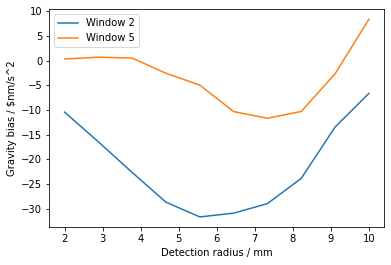

In [14]:
fig, ax = plt.subplots()
ax.plot(1e3*r_dets, ais.convert.rad_to_grav(np.angle(awf_win2)), label='Window 2')
ax.plot(1e3*r_dets, ais.convert.rad_to_grav(np.angle(awf_win5)), label='Window 5')
ax.set_xlabel('Detection radius / mm')
ax.set_ylabel('Gravity bias / $nm/s^2');
ax.legend()

### Rabi oscillations with a Gaussian beam

We simulate the decay of Rabi oscillation in the presence of thermal motion. Note that at the moment this only includes the motion within the $x$-$y$ plane and the motion in the $z$ is neglected.

#### Detector

Setting up da detector with a fixed detection radius and time.

In [17]:
t_det = 778e-3 # time of the detection in s
r_det = 5e-3 # size of detected region in x-y plane

det = ais.Detector(r_det, t_det) # set detection region

#### Atomic cloud and state vectors

Here we use a Monte-Carlo method by randomly drawing positions and velocities from a distribution. We initialize all atoms in the excited state, represented by a state vector `[0, 1]`.

In [18]:
pos_params = {
     'mean_x': 0.0,
     'std_x' : 3.0e-3, # cloud radius in m
     'mean_y': 0.0,
     'std_y' : 3.0e-3, # cloud radius in m
     'mean_z': 0.0,
     'std_z' : 0,        # ignore z dimension, its not relevant here
}
vel_params = {
     'mean_vx': 0.0,
     'std_vx' : ais.convert.vel_from_temp(3.0e-6), # cloud velocity spread in m/s at tempearture of 3 uK
     'mean_vy': 0.0,
     'std_vy' : ais.convert.vel_from_temp(3.0e-6), # cloud velocity spread in m/s at tempearture of 3 uK
     'mean_vz': 0.0,
     'std_vz' : 0,        # ignore z dimension, its not relevant here
}

atoms = ais.create_random_ensemble_from_gaussian_distribution(
    pos_params,
    vel_params, int(1e4),
    state_vectors=[0, 1])

We visualize the spread of the atomic ensemble and its convolution with the detector.

Text(0, 0.5, 'y / mm')

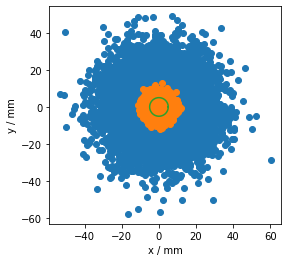

In [19]:
x0 = atoms.initial_position[:, 0]
y0 = atoms.initial_position[:, 1]

x_det = atoms.calc_position(t_det)[:, 0]
y_det = atoms.calc_position(t_det)[:, 1]

fig, ax = plt.subplots()
ax.scatter(1e3*x_det, 1e3*y_det, label='cloud at detection')
ax.scatter(1e3*x0, 1e3*y0, label='initial cloud')
angle = np.linspace(0, 2*np.pi, 100)
ax.plot(1e3*r_det*np.cos(angle), 1e3*r_det*np.sin(angle), c='C2', label='detection region')

ax.set_aspect('equal', 'box')

ax.set_xlabel('x / mm')
ax.set_ylabel('y / mm')

In [20]:
n_init = len(atoms)
atoms = det.detected_atoms(atoms)

print("{} of the initial {} atoms are detected. That's {}%".format(len(atoms), n_init, len(atoms)/n_init*100))

645 of the initial 10000 atoms are detected. That's 6.45%


#### Intensity profile

We set up an intensity profile of the interferometry laser, defined by the center Rabi frequency

In [21]:
center_rabi_freq = 2*np.pi*12.5e3 # center Rabi frequency in Hz
r_beam = 29.5e-3/2 # 1/e^2 beam radius in m
intensity_profile = ais.IntensityProfile(r_beam, center_rabi_freq)

#### Simulation

First, we freely propagate the atomic ensemble to the time when we start the Rabi oscillations by applying a light pulse.

In [22]:
t1 = 129.972e-3 # time of first pulse in s
atoms = ais.prop.free_evolution(atoms, t1)

The current position of the atoms is stored in `atoms.positions` and the `tim` attribute has changed accordingly:

In [23]:
atoms.time

0.129972

We now simulate the effect of the pulse length in two different ways. First, we neglect the motion of the atoms during the pulse by starting each run of the simulation with the initial state vector and atomic ensemble:

In [24]:
state_occupation_simple = []
taus = np.arange(200)*1e-6
for tau in taus:
    # acting on the states in `atom` at each run
    propagated_atoms = ais.prop.transition(atoms, intensity_profile, tau, wf=None)
    # mean occupation of the excited state
    state_occupation_simple.append(np.mean(propagated_atoms.state_occupation(state=1))) 

The `atoms` object is still at the initial time but `propagated_atoms` has changed:

In [25]:
print(atoms.time)
print(propagated_atoms.time)

0.129972
0.130171


In [26]:
state_occupation_motion = []
taus = np.arange(200)*1e-6
for tau in taus:
    # mean occupation of the excited state, include tau=0
    state_occupation_motion.append(np.mean(atoms.state_occupation(state=1))) 
    # propagating 1 us at a time, changing the `atoms` object at each step
    atoms = ais.prop.transition(atoms, intensity_profile, 1e-6, wf=None)

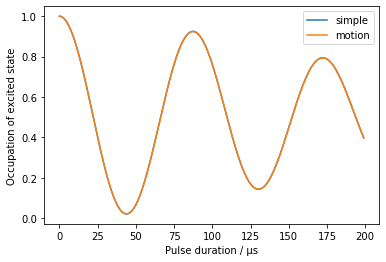

In [27]:
fig, ax = plt.subplots()
ax.plot(1e6*taus, state_occupation_simple, label='simple')
ax.plot(1e6*taus, state_occupation_motion, label='motion')
ax.set_xlabel('Pulse duration / μs')
ax.set_ylabel('Occupation of excited state');
ax.legend()

As expected, the motion during the pulse can be neglected.